In [1]:
!pip install torch==1.12.1
!pip install torchvision==0.13.1
!pip install matplotlib==3.5.2
!pip install scikit-image==0.19.3
!pip install captum==0.5.0

  Using cached torch-1.12.1-cp39-none-macosx_10_9_x86_64.whl (133.8 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0
    Uninstalling torch-1.12.0:
      Successfully uninstalled torch-1.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.7.7 requires typing-extensions>=4.0.0, but you have typing-extensions 3.7.4.3 which is incompatible.


## import modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import visualization as viz

In [3]:
np.random.seed(123)
torch.use_deterministic_algorithms(True)

## define model architecture

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## define training and inference routines

In [5]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))

In [6]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))

## create data loaders

In [7]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=True)

## define optimizer and run training epochs

In [8]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

## model training

In [9]:
for epoch in range(1, 2):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

/Users/ashish.jha/opt/anaconda3/envs/mastering_pytorch_7_chaps/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.310609
epoch: 1 [320/60000 (1%)]	 training loss: 1.924133
epoch: 1 [640/60000 (1%)]	 training loss: 1.313336
epoch: 1 [960/60000 (2%)]	 training loss: 0.796470
epoch: 1 [1280/60000 (2%)]	 training loss: 0.819801
epoch: 1 [1600/60000 (3%)]	 training loss: 0.678430
epoch: 1 [1920/60000 (3%)]	 training loss: 0.477187
epoch: 1 [2240/60000 (4%)]	 training loss: 0.529062
epoch: 1 [2560/60000 (4%)]	 training loss: 0.468829
epoch: 1 [2880/60000 (5%)]	 training loss: 0.242887
epoch: 1 [3200/60000 (5%)]	 training loss: 0.519632
epoch: 1 [3520/60000 (6%)]	 training loss: 0.262917
epoch: 1 [3840/60000 (6%)]	 training loss: 0.467169
epoch: 1 [4160/60000 (7%)]	 training loss: 0.424967
epoch: 1 [4480/60000 (7%)]	 training loss: 0.316685
epoch: 1 [4800/60000 (8%)]	 training loss: 0.497946
epoch: 1 [5120/60000 (9%)]	 training loss: 0.154707
epoch: 1 [5440/60000 (9%)]	 training loss: 0.371073
epoch: 1 [5760/60000 (10%)]	 training loss: 0.083154
epoch: 1 [6080/60

epoch: 1 [48960/60000 (82%)]	 training loss: 0.064825
epoch: 1 [49280/60000 (82%)]	 training loss: 0.186619
epoch: 1 [49600/60000 (83%)]	 training loss: 0.234463
epoch: 1 [49920/60000 (83%)]	 training loss: 0.135859
epoch: 1 [50240/60000 (84%)]	 training loss: 0.060284
epoch: 1 [50560/60000 (84%)]	 training loss: 0.006255
epoch: 1 [50880/60000 (85%)]	 training loss: 0.006335
epoch: 1 [51200/60000 (85%)]	 training loss: 0.230939
epoch: 1 [51520/60000 (86%)]	 training loss: 0.028286
epoch: 1 [51840/60000 (86%)]	 training loss: 0.009054
epoch: 1 [52160/60000 (87%)]	 training loss: 0.015087
epoch: 1 [52480/60000 (87%)]	 training loss: 0.012862
epoch: 1 [52800/60000 (88%)]	 training loss: 0.037046
epoch: 1 [53120/60000 (89%)]	 training loss: 0.027532
epoch: 1 [53440/60000 (89%)]	 training loss: 0.015318
epoch: 1 [53760/60000 (90%)]	 training loss: 0.067134
epoch: 1 [54080/60000 (90%)]	 training loss: 0.015243
epoch: 1 [54400/60000 (91%)]	 training loss: 0.090634
epoch: 1 [54720/60000 (91%)]

## run inference on trained model

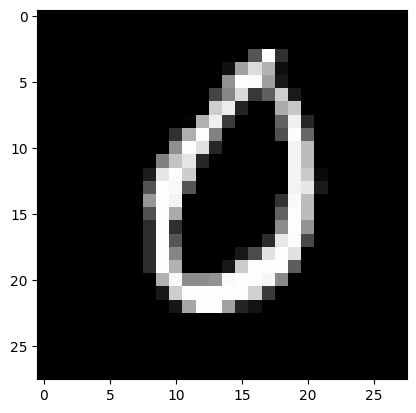

In [10]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [11]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 0
Ground truth is : 0


## captum tools

In [12]:
captum_input = sample_data[0].unsqueeze(0)
captum_input.requires_grad = True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


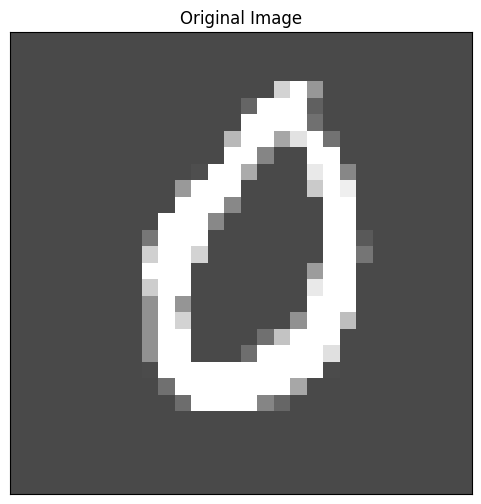

In [13]:
orig_image = np.tile(np.transpose((sample_data[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0)), (1,1,3))
# tmp = np.transpose((sample_data[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
# orig_image = np.concatenate([tmp, np.zeros(tmp.shape), np.zeros(tmp.shape)], axis=2)
_ = viz.visualize_image_attr(None, orig_image, cmap='gray', method="original_image", title="Original Image")

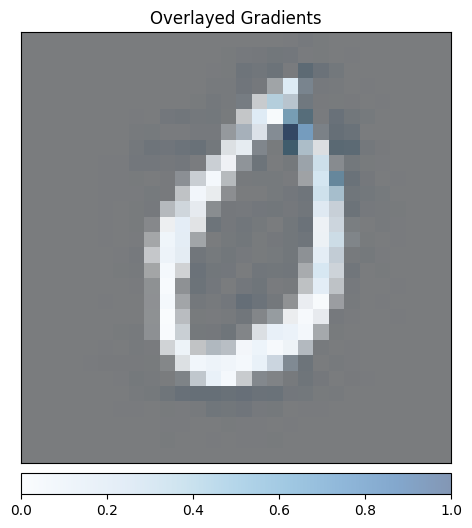

In [14]:
saliency = Saliency(model)
gradients = saliency.attribute(captum_input, target=sample_targets[0].item())
gradients = np.reshape(gradients.squeeze().cpu().detach().numpy(), (28, 28, 1))
_ = viz.visualize_image_attr(gradients, orig_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradients")

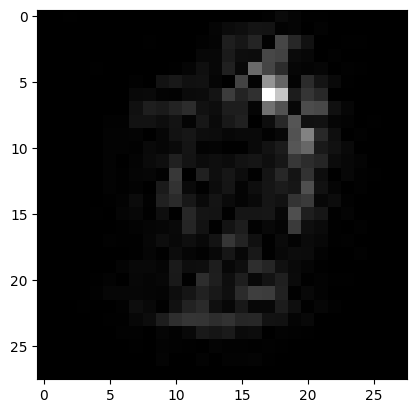

In [15]:
plt.imshow(np.tile(gradients/(np.max(gradients)), (1,1,3)));

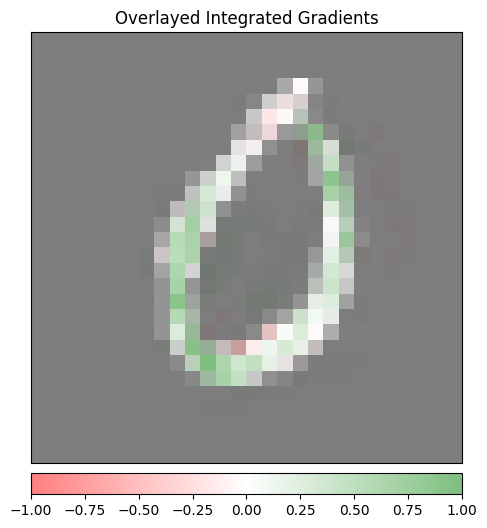

In [16]:
integ_grads = IntegratedGradients(model)
attributed_ig, delta = integ_grads.attribute(captum_input, target=sample_targets[0].item(), baselines=captum_input * 0, 
                              return_convergence_delta=True)
attributed_ig = np.reshape(attributed_ig.squeeze().cpu().detach().numpy(), (28, 28, 1))
_ = viz.visualize_image_attr(attributed_ig, orig_image, method="blended_heat_map",sign="all", show_colorbar=True, 
                             title="Overlayed Integrated Gradients")

/Users/ashish.jha/opt/anaconda3/envs/mastering_pytorch_7_chaps/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


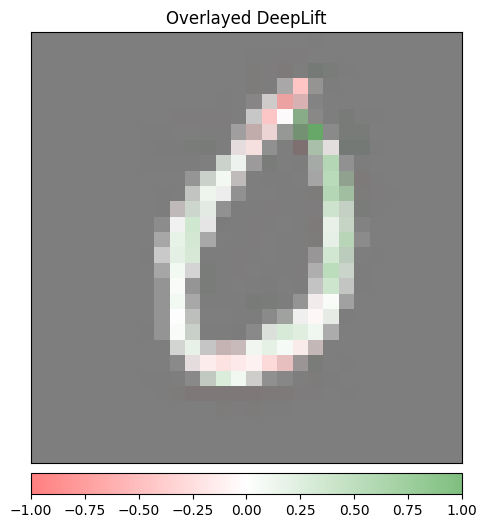

In [17]:
deep_lift = DeepLift(model)
attributed_dl = deep_lift.attribute(captum_input, target=sample_targets[0].item(), baselines=captum_input * 0, 
                              return_convergence_delta=False)
attributed_dl = np.reshape(attributed_dl.squeeze(0).cpu().detach().numpy(), (28, 28, 1))
_ = viz.visualize_image_attr(attributed_dl, orig_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")